<a href="https://colab.research.google.com/github/hiebschi/MoSE/blob/main/notebooks/02_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **02 Training**


## 1. Preparations
### 1.1 Import required packages

In [1]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib

In [2]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


### 1.2 Install segmentation model library

In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6ac0a332ebff5458ee9af6291784839124926e03cf48702a6925a4ba830040c3
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c17d72cbf64baffad220823a0bc179b14da61f8cf76cc3671eea20f398aa711b
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [5]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Google Drive Mounting

In [7]:
# access to my personal google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1.5 Import data directories

In [8]:
import os
print(os.path.abspath("configs"))

/content/configs


In [9]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/'))

In [10]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_gc' from '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/configs/configs_gc.py'>

In [11]:
# input directories: patches and masks
preprocessed_patches_dir = configs_sc.DATA_DIR["preprocessed_patches_unz"]
masks_dir = configs_sc.DATA_DIR["masks_ohe"]

# output directories: trained models
saved_model_dir = configs_sc.DATA_DIR["saved_models"]

# additional directories: class labels and codes
labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.6 Check the data

a. Class codes dict

In [12]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

print(codes)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
print(reversed_codes[4])
print(reversed_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9, 'Hintergrund': 0}
Totholz
{1: 'Einzelstein', 2: 'Wurzelstock', 3: 'Steinverbauung', 4: 'Totholz', 5: 'Steinriegel', 6: 'Schotterbank', 7: 'Schlamm_Sandinsel', 8: 'Sand_Schlammbank', 9: 'Schotterinsel', 0: 'Hintergrund'}


b. Preprocessed patches

In [13]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npy')]
patches_list[0:3], len(patches_list)

(['A05_patch_397.npy', 'A05_patch_40.npy', 'A05_patch_405.npy'], 3047)

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: -0.5852690845132008
Minimum value: -2.1179039301310043
Maximum value: 2.273986928104575


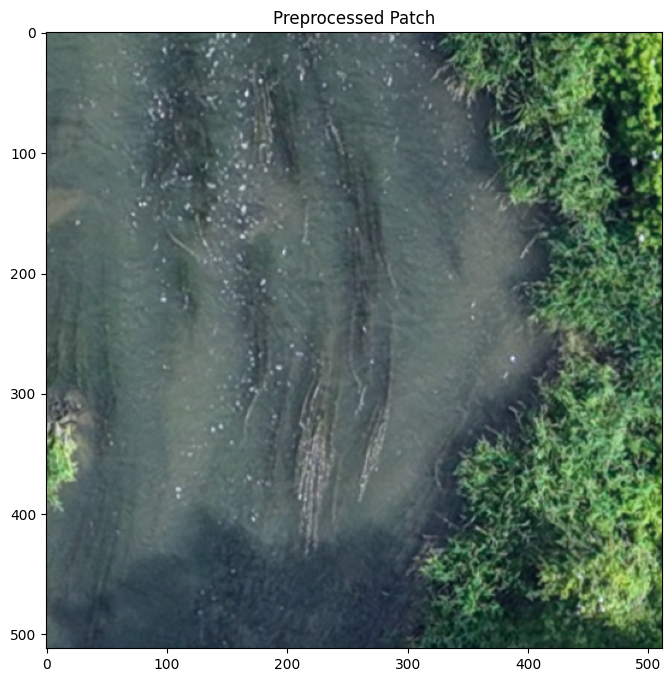

In [14]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 16 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch)

3. Masks

In [15]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
masks_list[0:3]

['A01_patch_0_mask.npy', 'A01_patch_103_mask.npy', 'A01_patch_104_mask.npy']

Shape of the mask: (10, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


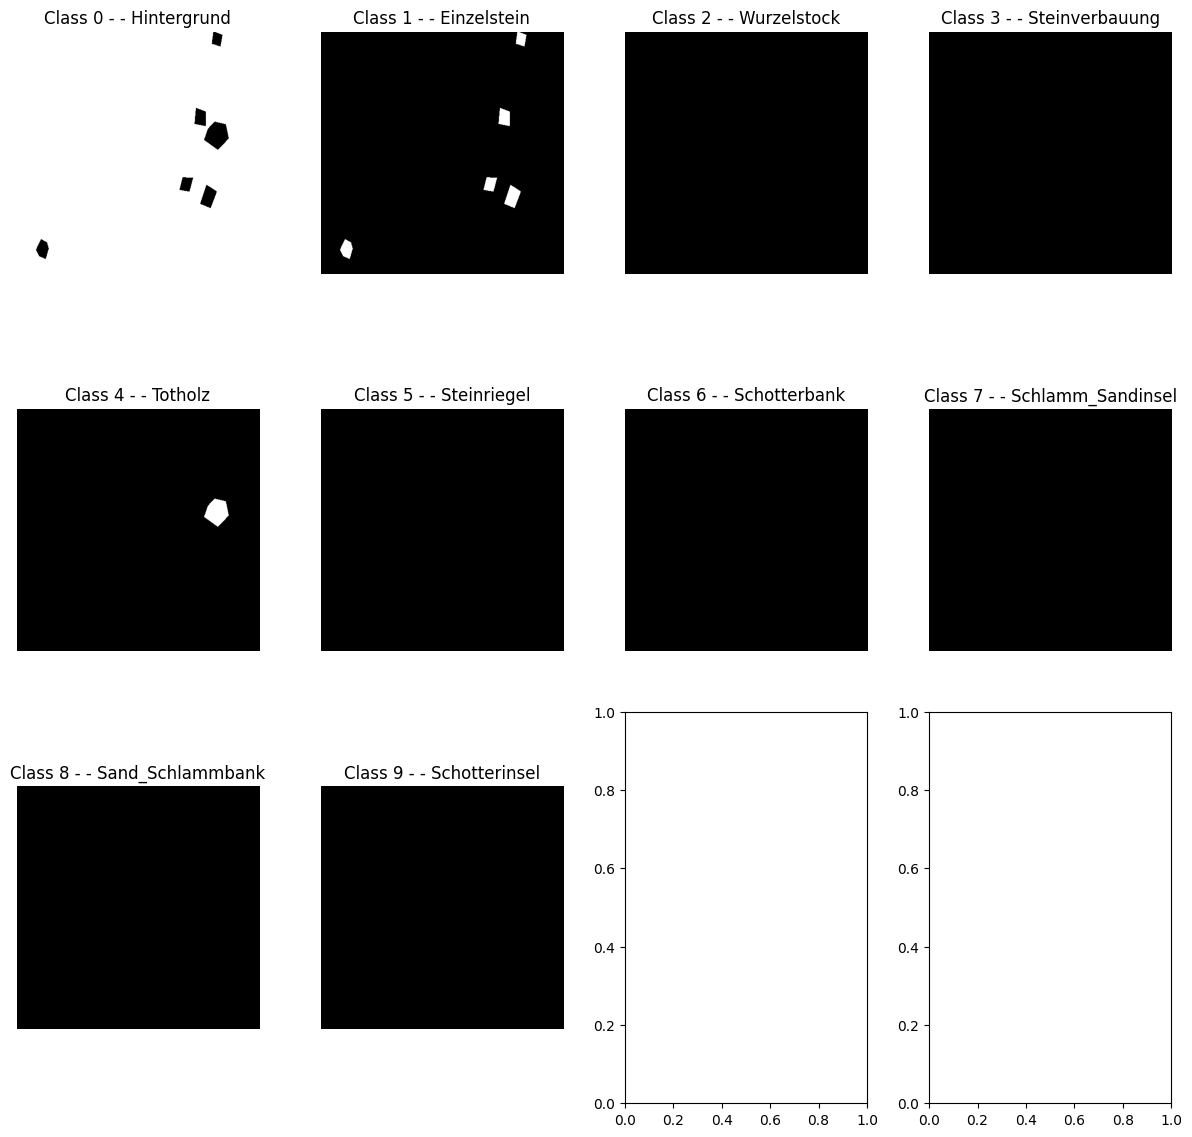

In [16]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 96 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
################################################################################
fig, axes = plt.subplots(3, 4, figsize=(12, 12))  # 3x4 grid (for 10 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Splitting data into train and test datasets

In [17]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

<module 'scripts.data_utils' from '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/scripts/data_utils.py'>

In [18]:
# extract section and patch_id from masks and patches (utils function)
print(data_utils.extract_section_and_id(masks_list[1]))
print(data_utils.extract_section_and_id(patches_list[175]))

('A01', '103')
('A05', '911')


In [19]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A05', 'A06', 'A07', 'A08', 'A04', 'A01', 'A02', 'A03'])


In [20]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")

Training Patches: 2323
Test Patches: 724


In [21]:
# Show random patch name in training data
print(train_data[8])

# test if this random patch has a corresponding mask
data_utils.has_mask(train_data[8], masks_dir)

A05_patch_410.npy


True

In [22]:
# Separate training and test patches according to whether they have a corresponding mask into label patches and background patches
################################################################################

train_with_masks = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
train_background = [f for f in train_data if not data_utils.has_mask(f, masks_dir)]
test_with_masks = [f for f in test_data if data_utils.has_mask(f, masks_dir)]
test_background = [f for f in test_data if not data_utils.has_mask(f, masks_dir)]

print(f"Training with masks - Number of patches: {len(train_with_masks)}")
print(f"Training background: {len(train_background)}")
print(f"Test with masks - Number of patches: {len(test_with_masks)}")
print(f"Test background: {len(test_background)}")

Training with masks - Number of patches: 2323
Training background: 0
Test with masks - Number of patches: 724
Test background: 0


In [23]:
# # import data_utils.py helper-functions script
# from scripts import miscellaneous_utils
# importlib.reload(miscellaneous_utils) # reload changes

In [24]:
# # Delete background patches
# miscellaneous_utils.delete_background_patches(train_data, preprocessed_patches_dir, masks_dir)
# miscellaneous_utils.delete_background_patches(test_data, preprocessed_patches_dir, masks_dir)

## 3. Dataset and DataLoader

### 3.1 Patch loading functions

In [25]:
# data_utils.load_npz_patch(train_with_masks[1], preprocessed_patches_dir)
# data_utils.parallel_load_npz(train_with_masks[1], preprocessed_patches_dir)

### 3.2 Dataset

In [26]:
# Apply Datasets and check properties
################################################################################

# Train dataset (with masks)
train_dataset = data_utils.PatchDataset(train_with_masks, preprocessed_patches_dir, masks_dir, preload = False)
# ATTENTION!: "preload = True" leads to crash because of an overuse of cpu-RAM!

# check properties of the mask dataset:
print("Train dataset with class labels:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

# # Train dataset without mask (background)
# train_background_dataset = data_utils.PatchDataset(train_background, preprocessed_patches_dir) # background

# # check properties of the background dataset:
# print("Train dataset without any class labels = background:\n")
# print("Type of dataset:", type(train_background_dataset))
# print("Number of patches:", len(train_background_dataset))
# print("Random patch:", train_background_dataset[0][0])
# print("Patch shape:", train_background_dataset[0][1].shape)
# print("Mask shape:", train_background_dataset[0][2].shape)

# Test datasets
test_dataset = data_utils.PatchDataset(test_with_masks, preprocessed_patches_dir, masks_dir) # with masks
# test_background_dataset = data_utils.PatchDataset(test_background, preprocessed_patches_dir) # background

Train dataset with class labels:

Type of dataset: <class 'scripts.data_utils.PatchDataset'>
Number of patches: 2323
Random patch: A05_patch_397.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([10, 512, 512]) 



### 3.3 DataLoader

Right now our data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into a model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [27]:
from torch.utils.data import DataLoader

# Combine Masked and Background datasets into one DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# print("Dataloader:", train_loader)
# train_background_loader = DataLoader(train_background_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_background_loader = DataLoader(test_background_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
# print(f"Training Background Batches: {len(train_background_loader)}")
print(f"Test Batches: {len(test_loader)}")
# print(f"Test Background Batches: {len(test_background_loader)}")

Training Batches: 291 = up to 2328 patches
Test Batches: 91


### 3.4 Data exploration

In [28]:
# # Explore one batch of data in train_loader
# for batch_idx, (names, images, masks) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
#     print(f"Names - fourth (last) patch name of the batch: {names[3]}", "\n------------")
#     print(f"Image type: {type(images)}")
#     print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
#     print(f"Image excerpt of the fourth patch: {images[3,:,:4,:4]}")
#     print(f"Images dtype: {images.dtype}", "\n------------")
#     print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
#     print(f"Mask excerpt of the mask of the fourth patch: {masks[3,:,:2,:2]}")
#     print(f"Masks dtype: {masks.dtype}")
#     break # break after first batch (batch 1)

In [ ]:
# # Check if there are any labels of class "Totholz" in one batch in the train_loader
# for batch_idx, batch in enumerate(train_loader):
#     patch_names, images, masks = batch

#     # extract mask for class 4 "Totholz"
#     class_4_mask = masks[:, 3, :, :]
#     # print(class_4_mask.shape, "\n") # [batch_size (number of patches), height, width]

#     # test if there are any labels for class 4 "Totholz"
#     has_class_4_labels = (class_4_mask > 0).any().item()

#     # print batch and if there are any labels for class 4
#     print(f"Batch {batch_idx + 1}:")
#     print(f"Contains class 4 labels: {has_class_4_labels}")

#     # if there are any labels for class 4 in one patch, print the names of the patch
#     if has_class_4_labels:
#         for i, patch_name in enumerate(patch_names):
#             if (class_4_mask[i] > 0).any().item():
#                 print(f"Patch with class 4 labels: {patch_name}")
#     break # break after first batch

In [ ]:
# # Show average pixel distribution in train_loader

# pixel_distribution_train = data_utils.average_pixel_distribution_dataloader(
#     data_loader=train_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# import matplotlib.pyplot as plt

# plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Train Dataset)")
# plt.xticks(rotation=45)
# plt.show()


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the average pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Weight |
| ----- | ----- | ----- |
| 0 | 96.05 | 1.0 |
| 1 | 0.07 | 1e-6 (placeholder) |
| 2 | 0.19 | 505.26 |
| 3 | 0.00 | 1e-6 (placeholder) |
| 4 | 2.39 | 40.17 |
| 5 | 0.03 | 1e-6 (placeholder) |
| 6 | 0.43 | 232.56 |
| 7 | 0.08 | 1e-6 (placeholder) |
| 8 | 0.60 | 160.08 |
| 9 | 0.15 | 641.67 |

alles normalisieren

Weights were calculated using the following formula:

weight = 1 / (pixel distribution/100)

For classes with an average pixel distribution below 0.1%, a placeholder value of 1e-6 is used to ensure that they do not dominate during training.

In [29]:
# define the weights to outweigh the class imbalances
class_weights = torch.tensor([1.0/641.67, (1e-6)/641.67, 505.26/641.67, (1e-6)/641.67, 40.17/641.67, (1e-6)/641.67, 232.56/641.67, (1e-6)/641.67, 160.08/641.67, 641.67/641.67], dtype=torch.float32).to(device)
print(class_weights.shape)

torch.Size([10])


## 4. Segmentation model

Unet_ is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use concatenation for fusing decoder blocks with skip connections.

URL: https://smp.readthedocs.io/en/latest/models.html#unet

``class segmentation_models_pytorch.Unet(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None, **kwargs)``


In [ ]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18", # choose encoder, e.g. mobilenet_v2 or       efficientnet-b7
#     encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3, # model input channels (3 for RGB)
#     classes=len(codes), # model output channels (number of classes)
# ).to(device)
################################################################################

In [30]:
# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 323MB/s]


<module 'scripts.model_utils' from '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/scripts/model_utils.py'>

In [31]:
model = model_utils.model_0.to(device)

In [ ]:
# show model costruction
# model.to(device)

In [ ]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [ ]:
next(model.parameters()).device

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [33]:
# Setup loss function
# loss_fn = smp.losses.DiceLoss(mode="multilabel")
# loss_fn = model_utils.DiceLoss_fn
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

``segmentation_models_pytorch.losses.constants.MULTILABEL_MODE: str = 'multilabel'``    
**Loss multilabel mode** suppose you are solving multi-label segmentation task. That mean you have **C = 1..N classes which pixels are labeled as 1**, classes are **not mutually exclusive** and **each class have its own channel**, pixels in each channel which are not belong to class labeled as 0. Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W).

In [34]:
# Setup optimizer

# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

# # Scheduler for learning rate decay (optional)
# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # learning rate will be reduced every 10 epochs with factor 0.1

Evaluation metrics

In [35]:
# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

<module 'scripts.evaluation_utils' from '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/scripts/evaluation_utils.py'>

In [36]:
accuracy_fn = evaluation_utils.accuracy_fn

In [ ]:
# # Dice similarity coefficient (DSC) aka F1-Score for segmentation tasks
# DSC_per_class = evaluation_utils.DSC_per_class

### 4.2 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all.

In [37]:
# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

<module 'scripts.train_utils' from '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/MoSE_repo/scripts/train_utils.py'>

In [ ]:
## Check model structure
# print(model)

In [38]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# measure time with timing function
from timeit import default_timer as timer
start = timer()

train_loss_progress = []
test_loss_progress = []

for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})

    test_loss_epoch = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
tensor([0, 1, 2, 4, 8], device='cuda:0')
Logits Shape: torch.Size([8, 10, 512, 512]), Min: -8.341349601745605, Max: 7.067471504211426
Targets Shape: torch.Size([8, 512, 512]), Unique: tensor([0, 1, 2, 4, 8], device='cuda:0')
Train Loss of [Batch 0/291]: 2.4417
tensor([0, 1, 3, 4, 8], device='cuda:0')
Logits Shape: torch.Size([8, 10, 512, 512]), Min: -8.680174827575684, Max: 7.6581268310546875
Targets Shape: torch.Size([8, 512, 512]), Unique: tensor([0, 1, 3, 4, 8], device='cuda:0')
tensor([0, 2, 4, 6, 8], device='cuda:0')
Logits Shape: torch.Size([8, 10, 512, 512]), Min: -11.042057037353516, Max: 8.568532943725586
Targets Shape: torch.Size([8, 512, 512]), Unique: tensor([0, 2, 4, 6, 8], device='cuda:0')
tensor([0, 1, 2, 4, 6, 8], device='cuda:0')
Logits Shape: torch.Size([8, 10, 512, 512]), Min: -7.149070739746094, Max: 6.845766067504883
Targets Shape: torch.Size([8, 512, 512]), Unique: tensor([0, 1, 2, 4, 6, 8], device='cuda:0')
tensor([0, 4, 6, 8], device='cuda:0')

KeyboardInterrupt: 

### 4.4 Evaluate model

In [ ]:
# def eval_model(model: torch.nn.Module,
#                data_loader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                accuracy_fn,
#                device = device):

#     """Returns a dictionary containing the results of model predicting on data_loader.

#     Args:
#         model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
#         data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
#         loss_fn (torch.nn.Module): The loss function of model.
#         accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

#     Returns:
#         (dict): Results of model making predictions on data_loader.
#     """

#     loss, acc = 0, 0
#     model.eval()
#     with torch.inference_mode():
#         for name, X, y in tqdm(data_loader):
#             # Make our data device agnostic
#             X, y = X.to(device), y.to(device)

#             # Make predictions with the model
#             y_pred = model(X).to(device)

#             # Accumulate the loss and accuracy values per batch
#             loss += loss_fn(y_pred, y)
#             acc += accuracy_fn(y_true=y,
#                                 y_pred=y_pred.argmax(dim=0)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

#         # Scale loss and acc to find the average loss/acc per batch
#         loss /= len(data_loader)
#         acc /= len(data_loader)

#     return {"model_name": model.__class__.__name__, # only works when model was created with a class
#             "model_loss": loss.item(),
#             "model_acc": acc}

In [ ]:
# torch.manual_seed(42)
# # Calculate model results on test dataset
# model_results = eval_model(model=model.to(device), data_loader=test_loader,
#     loss_fn=loss_fn, accuracy_fn=accuracy_fn
# )
# model_results

Visual Evaluation

A06_patch_1432.npy


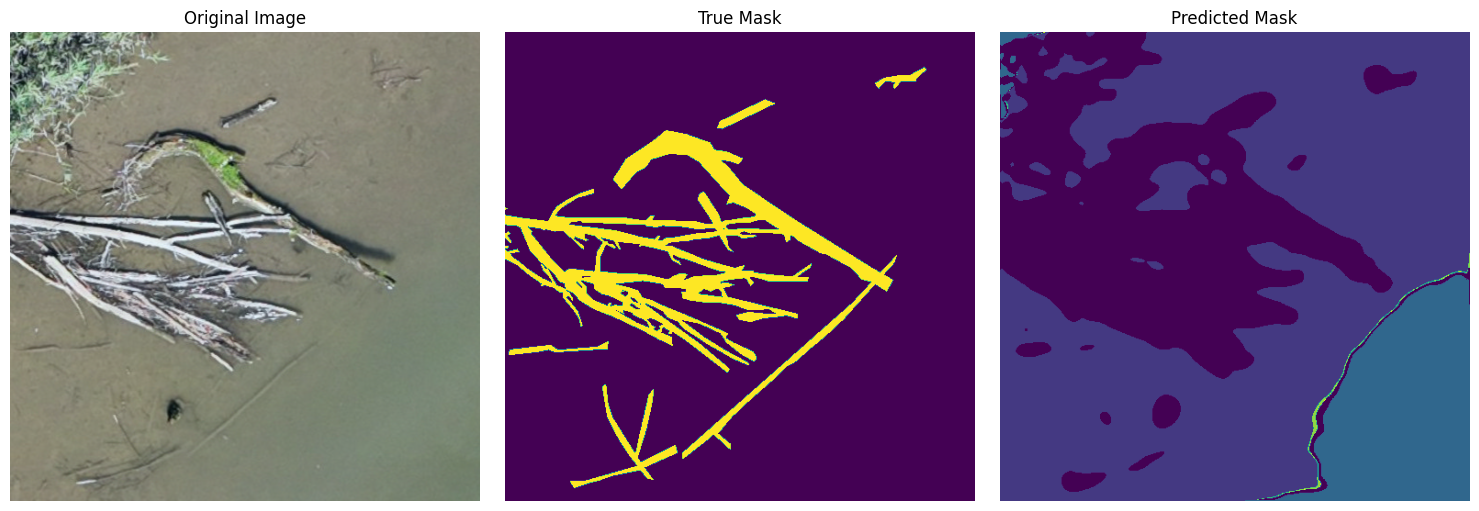

In [ ]:
# # Visualization
# import matplotlib.pyplot as plt

# # Choose batch
# batch_idx = 29

# for i, (names, images, masks) in enumerate(test_loader):
#   if i == batch_idx:

#     images, masks = images.to(device), masks.to(device)

#     # Choose one patch in this batch)
#     patch_idx = 1 # second patch
#     patch_name = names[patch_idx]
#     print(patch_name)

#     # RGB image
#     t_image = images[patch_idx].permute(1, 2, 0).cpu().numpy() # [C, H, W] -> [H, W, C]

#     # True mask (with argmax from [num_classes, H, W] to [H, W])
#     t_true_mask = masks[patch_idx].cpu().numpy().argmax(axis=0)

#     # Predicted mask (with argmax from [num_classes, H, W] to [H, W])
#     t_logits = model(images[patch_idx].unsqueeze(dim=0))
#     t_pred_probs = torch.sigmoid(t_logits)
#     t_pred_mask = torch.round(torch.sigmoid(t_logits)).cpu().detach()
#     t_pred_mask = t_pred_mask.squeeze().numpy().argmax(axis=0)

#     break

# # Normalization of the RGB image
# t_image = (t_image - t_image.min()) / (t_image.max() - t_image.min())

# # Visualization
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(t_image)
# axes[0].set_title("Original Image")
# axes[0].axis("off")

# axes[1].imshow(t_true_mask, cmap="viridis")
# axes[1].set_title("True Mask")
# axes[1].axis("off")

# axes[2].imshow(t_pred_mask, cmap="viridis")
# axes[2].set_title("Predicted Mask")
# axes[2].axis("off")

# plt.tight_layout()
# plt.show()

In [ ]:
# def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
#     pred_probs = []
#     model.to(device)
#     model.eval()
#     with torch.inference_mode():
#         for sample in data:
#             # Prepare sample
#             sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

#             # Forward pass (model outputs raw logit)
#             pred_logit = model(sample)

#             # Get prediction probability (logit -> prediction probability)
#             pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

#             # Get pred_prob off GPU for further calculations
#             pred_probs.append(pred_prob.cpu())

#     # Stack the pred_probs to turn list into a tensor
#     return torch.stack(pred_probs)

## 5. Save and load model

Preparations

In [ ]:
# Create model name and corresponding path
MODEL_NAME = "test_unet_model_0.pth" # ----------------------> ADJUSTABLE!
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

Save model

In [ ]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Load model

In [ ]:
# Load model
# Create a new instance of the model (same class as our saved state_dict())
loaded_model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
).to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path))

# Send model to GPU
loaded_model = loaded_model.to(device)

Evaluate and test loaded model

In [ ]:
# # Evaluate loaded model
# torch.manual_seed(42)

# loaded_model_results = eval_model(
#     model=loaded_model,
#     data_loader=test_loader,
#     loss_fn=loss_fn,
#     accuracy_fn=accuracy_fn
# )

# loaded_model_results

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }